# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn"))

from data import isic_archive_load
from auc_metric import calculate_auc
from gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

### Model description

- Model architecture: Inception ResNet V2 
- Fractal module used: None 
- Number of layers tuned: 1 

### Load the ISIC Archive dataset

In [3]:
training_set, testing_set, validation_set = isic_archive_load()

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/data/isic_archive.py:20: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


### Model definition and callbacks

In [4]:
class LesionClassifier(tf.keras.Model):
    def __init__(self, class_number):
        super(LesionClassifier, self).__init__()
        
        self.inside_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.inside_model.layers:
            if layer.name in ['conv_7b']:
                layer.trainable = True
            else:
                layer.trainable = False           
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        outputs = self.inside_model(inputs)
        outputs = self.dense(outputs)
        
        return outputs

In [5]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [6]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

### Training

In [7]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [8]:
with strategy.scope():
    model = LesionClassifier(class_number=len(training_set.class_indices))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [9]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1
947/947 [==============================] - ETA: 0s - loss: 0.7865 - accuracy: 0.7387
Epoch 1: val_loss improved from inf to 0.71210, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 8399s 9s/step - loss: 0.7865 - accuracy: 0.7387 - val_loss: 0.7121 - val_accuracy: 0.7542
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.7681
Epoch 2: val_loss improved from 0.71210 to 0.64920, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 7600s 8s/step - loss: 0.6698 - accuracy: 0.7681 - val_loss: 0.6492 - val_accuracy: 0.7732
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.7811
Epoch 3: val_loss improved from 0.64920 to 0.64250, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 6509s 7s/step - loss: 0.6299 - accuracy: 0.7811 - val_loss: 0.6425 - val_accuracy: 0.7751
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 0.5950 - accuracy: 0.7940
Epoch 4: val_loss improved from 0.64250 to 0.61764, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 5581s 6s/step - loss: 0.5950 - accuracy: 0.7940 - val_loss: 0.6176 - val_accuracy: 0.7835
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.8002
Epoch 5: val_loss did not improve from 0.61764
947/947 [==============================] - 4866s 5s/step - loss: 0.5727 - accuracy: 0.8002 - val_loss: 0.6342 - val_accuracy: 0.7811
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 0.5464 - accuracy: 0.8090
Epoch 6: val_loss improved from 0.61764 to 0.60622, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 4305s 5s/step - loss: 0.5464 - accuracy: 0.8090 - val_loss: 0.6062 - val_accuracy: 0.7885
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 0.5271 - accuracy: 0.8133
Epoch 7: val_loss improved from 0.60622 to 0.59602, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 4326s 5s/step - loss: 0.5271 - accuracy: 0.8133 - val_loss: 0.5960 - val_accuracy: 0.7914
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 0.5130 - accuracy: 0.8187
Epoch 8: val_loss did not improve from 0.59602
947/947 [==============================] - 4127s 4s/step - loss: 0.5130 - accuracy: 0.8187 - val_loss: 0.6086 - val_accuracy: 0.7918
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 0.4957 - accuracy: 0.8245 
Epoch 9: val_loss improved from 0.59602 to 0.59407, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 12660s 13s/step - loss: 0.4957 - accuracy: 0.8245 - val_loss: 0.5941 - val_accuracy: 0.7970
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 0.4836 - accuracy: 0.8277 
Epoch 10: val_loss improved from 0.59407 to 0.58373, saving model to checkpoints/model.ckpt


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 12534s 13s/step - loss: 0.4836 - accuracy: 0.8277 - val_loss: 0.5837 - val_accuracy: 0.7930
Epoch 11/30
947/947 [==============================] - ETA: 0s - loss: 0.4680 - accuracy: 0.8331 
Epoch 11: val_loss did not improve from 0.58373
947/947 [==============================] - 13049s 14s/step - loss: 0.4680 - accuracy: 0.8331 - val_loss: 0.6077 - val_accuracy: 0.7934
Epoch 12/30
947/947 [==============================] - ETA: 0s - loss: 0.4496 - accuracy: 0.8396 
Epoch 12: val_loss did not improve from 0.58373
947/947 [==============================] - 17795s 19s/step - loss: 0.4496 - accuracy: 0.8396 - val_loss: 0.6151 - val_accuracy: 0.7987
Epoch 13/30
947/947 [==============================] - ETA: 0s - loss: 0.4436 - accuracy: 0.8418 
Epoch 13: val_loss did not improve from 0.58373
947/947 [==============================] - 18578s 20s/step - loss: 0.4436 - accuracy: 0.8418 - val_loss: 0.6110 - val_accuracy: 0.7984
Epoch 14/30
947/947 [=

INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


INFO:tensorflow:Assets written to: checkpoints/model.ckpt/assets


947/947 [==============================] - 9435s 10s/step - loss: 0.4233 - accuracy: 0.8485 - val_loss: 0.5739 - val_accuracy: 0.8062


### Testing

In [10]:
model.load_weights(checkpoint_path)

In [11]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [12]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 271s 2s/step


In [13]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [14]:
auc_metric

{'actinic keratosis': 0.9489721886336155,
 'basal cell carcinoma': 0.9709661873299651,
 'dermatofibroma': 0.9511216033150052,
 'melanoma': 0.9022431837688437,
 'nevus': 0.9489734206747658,
 'pigmented benign keratosis': 0.9539617128902843,
 'seborrheic keratosis': 0.9424007602178769,
 'solar lentigo': 0.9458355564550255,
 'squamous cell carcinoma': 0.9534601564151342,
 'vascular lesion': 0.9892204686752749}

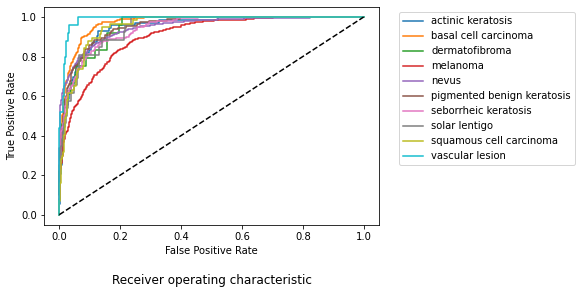

In [15]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

### GradCam

In [16]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

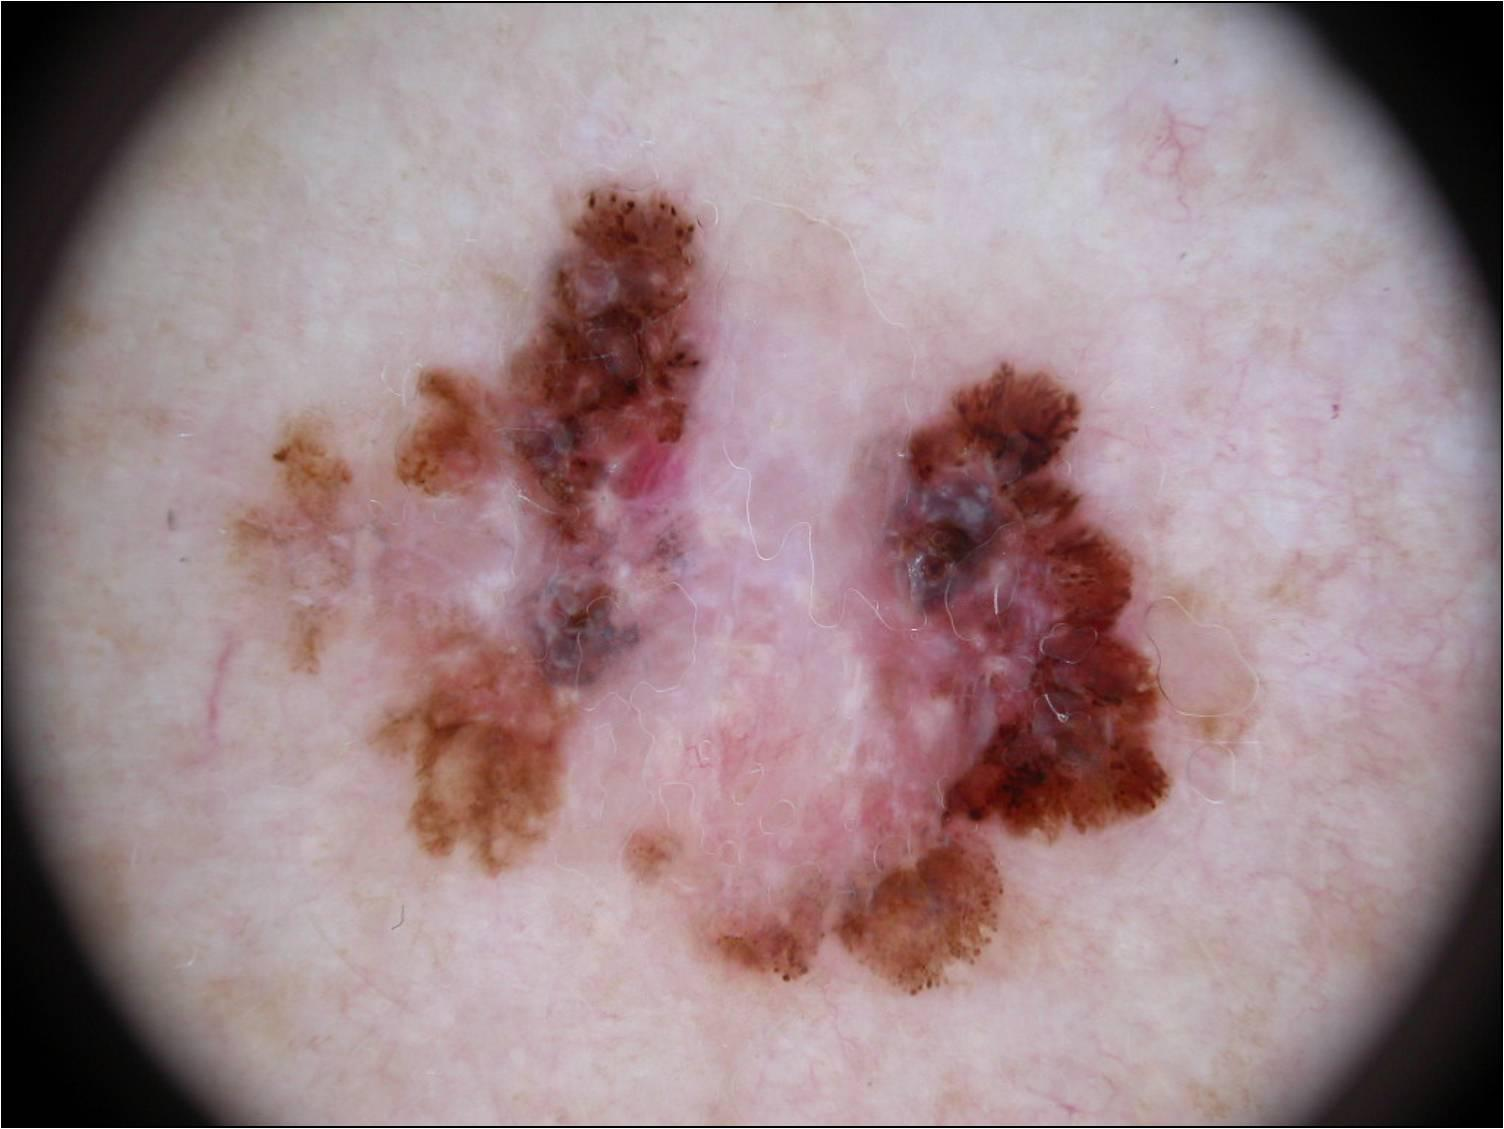

In [17]:
display(Image(melanoma_im_path, width=600))

In [18]:
img_array = tf.keras.applications.inception_resnet_v2.preprocess_input(get_img_array(melanoma_im_path, size=(299, 299)))

In [19]:
heatmap = make_gradcam_heatmap(img_array, model.inside_model, 'conv_7b')

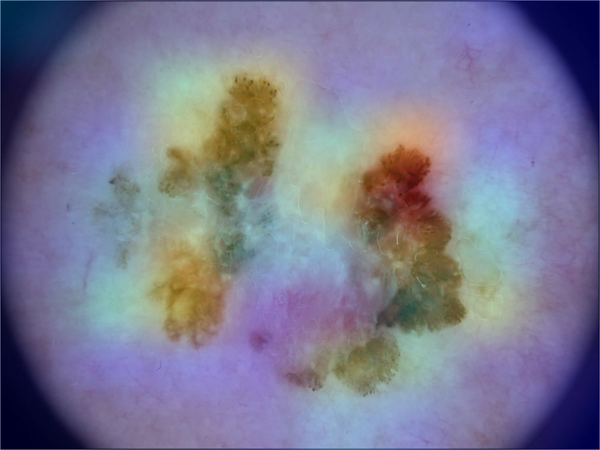

In [20]:
display_gradcam(melanoma_im_path, heatmap)

In [21]:
model.inside_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                               